# Momentum Iterative FGSM (MI-FGSM) | EPOCH Lab: Ricoh

According to [Adversarial machine learning at scale](https://arxiv.org/pdf/1611.01236.pdf), one-step attack is easy to transfer but also easy to defend (see Section VII-A). [Boosting adversarial attacks with momentum](https://arxiv.org/pdf/1710.06081.pdf) applied momentum to FGSM to generate adversarial examples more iteratively.

The gradients were calculated by: gt+1 = μgt + ∇xJθ(x′t, l) / ∥∇xJθ(x′t,l)

Then the adversarial example is derived by: x′t+1 = x′t + εsigngt+1

The authors increased the effectiveness of attack by introducing momentum and improved the transferability by applying the one-step attack and the ensembling method.

In [1]:
%pylab inline

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

Populating the interactive namespace from numpy and matplotlib


In [2]:
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

CUDA Available:  False


In [3]:
model = models.inception_v3(pretrained=True).to(device)
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [4]:
!curl https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt --output data/imagenet_classes.txt
    
with open("data/imagenet_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10472  100 10472    0     0  44515      0 --:--:-- --:--:-- --:--:-- 45333


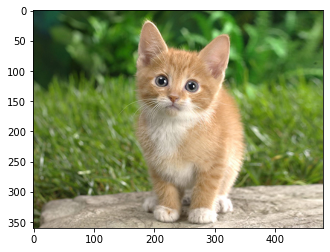

In [5]:
img = Image.open("/Volumes/artemis/library/datasets/cat.jpg")
plt.imshow(img)

In [6]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

In [7]:
input_tensor = preprocess(img).unsqueeze(0)

In [8]:
def predict(img):
    output = model(img)
    probs = F.softmax(output, dim=1)
    _, indicies = torch.topk(probs, k=1)
    for i in indicies.data.numpy().ravel():
        cost = probs.data[0][i]
        print("Class ID: {} | Label: {} | Accuracy: {}%".format(str(i), classes[i], 100 * cost))

In [9]:
predict(input_tensor)

Class ID: 282 | Label: tiger cat | Accuracy: 93.17092895507812%


In [10]:
image = input_tensor.clone()
target = torch.tensor(282).unsqueeze(0)    #Tiger cat

In [11]:
def mifgsm_attack(image, epsilon, gradient):
    steps = 10
    decay = 1.0
    alpha = epsilon/steps
    
    accum_grad = 0
    perturb_image = image
    
    for i in range(steps-1):
        accum_grad = decay * accum_grad + gradient / torch.norm(gradient, p=1)
        perturb_image = perturb_image + alpha * torch.sign(accum_grad)
        
    return perturb_image

In [12]:
epsilon = [0, .05, .1, .15, .2, .25, .3]

examples = []

for e in epsilon:
    image, target = image.to(device), target.to(device)

    image.requires_grad = True
    
    output = model(image)
    init_pred = output.max(1, keepdim=True)[1]
    
    loss = nn.CrossEntropyLoss()(output, target).to(device)
    
    model.zero_grad()
    loss.backward()
    
    gradient = image.grad.data
    
    perturb_data = mifgsm_attack(image, e, gradient)
    predict(perturb_data)
    
    output = model(perturb_data)
    final_pred = output.max(1, keepdim=True)[1]
    
    examples.append((init_pred, final_pred, perturb_data))

Class ID: 282 | Label: tiger cat | Accuracy: 93.17092895507812%
Class ID: 151 | Label: Chihuahua | Accuracy: 39.004180908203125%
Class ID: 151 | Label: Chihuahua | Accuracy: 21.47760581970215%
Class ID: 151 | Label: Chihuahua | Accuracy: 15.310211181640625%
Class ID: 333 | Label: hamster | Accuracy: 10.121856689453125%
Class ID: 333 | Label: hamster | Accuracy: 8.349041938781738%
Class ID: 333 | Label: hamster | Accuracy: 6.2524614334106445%


In [13]:
denorm = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
                             transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])])

In [14]:
def postprocess(data):
    image = denorm(data.squeeze()).detach().numpy()
    image = np.rollaxis(image, 0, 3)
    return image

In [15]:
index = 6
attack_image = postprocess(examples[index][2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tiger cat > hamster


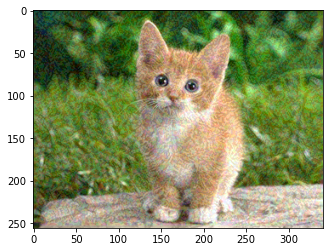

In [16]:
print(classes[examples[index][0]], ">", classes[examples[index][1]])
plt.imshow(attack_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


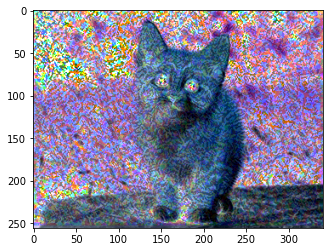

In [17]:
diff = (attack_image / postprocess(input_tensor)) - postprocess(input_tensor)
plt.imshow(diff)